In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import EfficientNetB0, InceptionV3, Xception
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import random

**Step 1: Load the Dataset of training images and the corresponding csv file that indicates the defect class the training image belongs.**

In [ ]:
# Step 1: Load the data (e.g., images and classes)

#train_df = pd.read_csv('data/train/train.csv')
train_df = pd.read_csv('/content/drive/MyDrive/data/train/train.csv')

# Path for image directory
#image_dir = 'data/train_images/'
#data_dir = '/content/drive/MyDrive/data/'
train_data_dir = '/content/drive/MyDrive/data/train_images/'
test_data_dir = '/content/drive/MyDrive/data/test_images/'


***Step 2: Know your dataset and pre-process the dataset. ***

In [ ]:
# Step 1a: Get the records available in training dataset
train_df.shape

(7095, 3)

In [ ]:
# Step 1b: Get the top 10 records available in training dataset
train_df.head()

,ImageId,ClassId,EncodedPixels
0,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0007a71bf.jpg,3,18661 28 18863 82 19091 110 19347 110 19603 11...
2,000a4bcdd.jpg,1,37607 3 37858 8 38108 14 38359 20 38610 25 388...
3,000f6bf48.jpg,4,131973 1 132228 4 132483 6 132738 8 132993 11 ...
4,0014fce06.jpg,3,229501 11 229741 33 229981 55 230221 77 230468...


In [ ]:
# Step 1c: Get the unique defect classes of Steel
train_df['ClassId'].unique()


array([1, 3, 4, 2])

In [ ]:
train_df['ClassId'].value_counts()

,count
ClassId,
3,5150
1,897
4,801
2,247


In [ ]:
# Check for null values in 'ClassId'
train_df[train_df['ClassId'].isnull()]

,ImageId,ClassId,EncodedPixels


In [ ]:
# Drop the null value record
train_df = train_df.dropna()

In [ ]:
# Check for any null values in 'EncodedPixels'
train_df[train_df['EncodedPixels'].isnull()].sum()

,0
ImageId,0
ClassId,0
EncodedPixels,0


In [ ]:
# Check for any null values in 'ImageId'
train_df[train_df['ImageId'].isnull()].sum()

,0
ImageId,0
ClassId,0
EncodedPixels,0


In [ ]:
#  The loss function `categorical_crossentropy` used in model runs expect integer labels, updating labels to zero-indexed.
train_df['ClassId'] = train_df['ClassId'] - 1
train_df['ClassId'].unique()

array([0, 2, 3, 1])

In [ ]:
# Step 2: Preprocess the images (resize, normalize)

# Image Directory Path
image_dir = train_data_dir

target_size = (224, 224)  # Resize all images to 224x224

# Initialize a list to hold the transformed trained data and its defect classes
X_train = []
y_train = []

# Loop through the dataframe to load images and labels
for index, row in tqdm(train_df.iterrows(), total=train_df.shape[0], mininterval=1.0):
    # Load and preprocess image
    img_path = os.path.join(image_dir, row['ImageId'])
    image_id = row['ImageId']
    if image_id.lower().endswith('.jpg'):
      img = load_img(img_path, target_size=target_size)  # Resize image
      img = img_to_array(img)  # Convert to numpy array
      X_train.append(img)
      y_train.append(row['ClassId'])  # Append corresponding class label

  0%|          | 0/7095 [00:00<?, ?it/s]

In [ ]:
# Convert to numpy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)

In [ ]:
# y_train are categorical labels
y_train = to_categorical(y_train, num_classes=train_df['ClassId'].nunique())

In [ ]:
# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)


In [ ]:
# Function to display the training image
def  plot_image(X, y, idx, train_df, image_dir): # Add train_df as an argument
  image_id = train_df.iloc[idx]['ImageId'].strip('"') # Get the ImageId from train_df
  image_path = os.path.join(image_dir, image_id)
  img = load_img(image_path)
  plt.figure(figsize=(10, 8))
  plt.imshow(img)
  plt.title(f"Defect: {y[idx]}")
  plt.show()

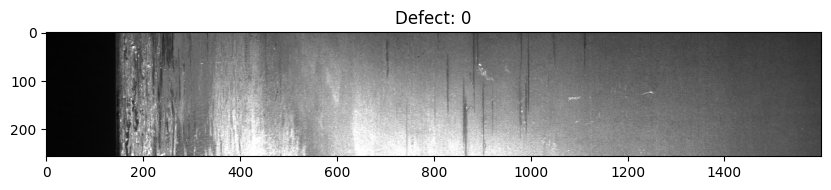

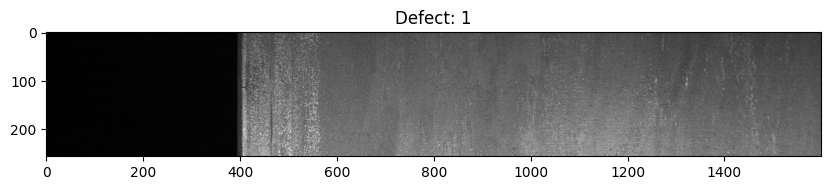

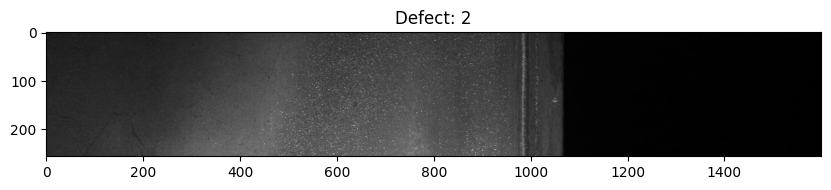

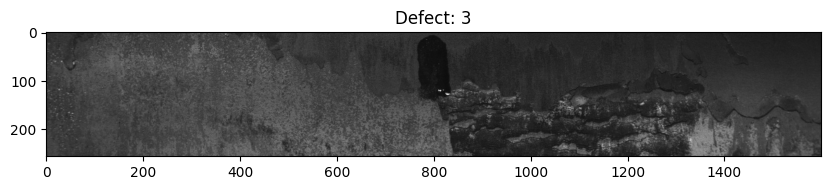

In [ ]:
# Display the image from each class
random_record_per_class = train_df.groupby('ClassId').sample(n=1, random_state=42)
for idx, row in random_record_per_class.iterrows():
    plot_image(random_record_per_class.drop('ClassId', axis=1), random_record_per_class['ClassId'] , idx, train_df, train_data_dir)

**Step 3: With limited training images we apply Data Augmentation, using images orientation and brighness parameter to existing training images.**

In [ ]:
# Apply the data augmentation
# Parameters
batch_size = 32

# Image Data Generator with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,               # Normalize the images
    shear_range=0.2,             # Random shear
    zoom_range=0.2,              # Random zoom
    horizontal_flip=True,        # Random horizontal flip
    vertical_flip=True,          # Random vertical flip
    brightness_range=[0.8, 1.2]  # Random brightness adjustment
)


# Image Data Generator for the validation set (only rescaling, no augmentation)
val_datagen = ImageDataGenerator(rescale=1./255)  # No augmentation on validation data

# Apply the data augmentation
train_generator = train_datagen.flow(X_train, y_train,  batch_size=batch_size, shuffle=True)
val_generator = val_datagen.flow(X_val, y_val, batch_size=batch_size, shuffle=False)


**Step 4: Identify and define the pre-trained models that will be used as part deep learning and fine tuning.**

In [ ]:
# Build and Compile Model
def build_compile_model(model_name, config):
    if model_name == 'InceptionV3':
        base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=config['input_shape'])
    elif model_name == 'EfficientNetB0':
        base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=config['input_shape'])
    elif model_name == 'Xception':
        base_model = Xception(weights='imagenet', include_top=False, input_shape=config['input_shape'])
    else:
        raise ValueError("No such model incorporated")

    # Freeze the convolutional base
    base_model.trainable = False

    # Add custom top layers
    x = base_model.output

    # Layer-1
    x = Conv2D(filters=32, kernel_size=3)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPooling2D(3, strides=2, padding="same")(x)
    # Layer-2
    x = Conv2D(filters=64, kernel_size=2)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPooling2D(2, strides=1, padding="same")(x)

    x = Dropout(0.2)(x)  # Dropout layer to prevent overfitting
    x = BatchNormalization()(x)
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)  # Dense layer
    x = Dense(128, activation='relu')(x)  # Dense layer
    output = Dense(config['num_classes'], activation='softmax')(x)  # Output layer

    # Define and create a final model
    model = Model(inputs=base_model.input, outputs=output)
    # Compile the model
    model.compile(optimizer=Adam(learning_rate=config['learning_rate'], clipvalue=config['clipvalue']), loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [ ]:
# Set up EarlyStopping callback to stop training when validation accuracy plateaus
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss (you can change this to 'val_accuracy' if you prefer)
    patience=5,           # Number of epochs with no improvement after which training will be stopped
    verbose=1,            # Print messages when early stopping is triggered
    restore_best_weights=True  # Restore the best weights when stopping
)
# Set up ModelCheckpoint to save the best model based on validation loss
model_checkpoint = ModelCheckpoint(
    'best_model.h5',  # Path where the model will be saved
    monitor='val_loss',  # Monitor the validation loss (you can change this to 'val_accuracy' if you prefer)
    save_best_only=True,  # Save only the best model
    mode='min',           # We want to minimize the loss
    verbose=1             # Print messages when the model is saved
)

In [ ]:
# Function to evaluate multiple models
def evaluate_models(models, config, train_generator, val_generator, batch_size=32, epochs=10 ):
    histories = {}
    for model_name in models:
        print(f"Training {model_name}...")
        model = build_compile_model(model_name, config)
        history = model.fit(
                            train_generator,  # Pass the generator
                            steps_per_epoch=len(train_df) // batch_size,  # Total samples divided by batch size
                            epochs=epochs,
                            validation_data=val_generator,  # If you have a validation generator, pass it here
                            callbacks=[early_stopping, model_checkpoint] # Use the callbacks
                        )
        histories[model_name] = {
                                'model': model,
                                'history': history,
                                'batch_size': batch_size,
                                'epochs': epochs
                                }
    return histories

In [ ]:
# Set up the parameters for the Model Run

# Models used
models = ['InceptionV3', 'EfficientNetB0', 'Xception']

# Define model configuration values in a dictionary
config = {
    'num_classes': train_df['ClassId'].nunique(),
    'input_shape': (224, 224, 3),
    'learning_rate': 0.0001,
    'clipvalue': 1.0
}

In [ ]:
# Run Model
epochs = 10
model_results = evaluate_models(models, config, train_generator, val_generator, batch_size=batch_size, epochs=epochs, )

Training InceptionV3...
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
178/221 ━━━━━━━━━━━━━━━━━━━━ 39s 918ms/step - accuracy: 0.6384 - loss: 0.9493

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 1: val_loss improved from inf to 0.63632, saving model to best_model.h5


221/221 ━━━━━━━━━━━━━━━━━━━━ 216s 931ms/step - accuracy: 0.6526 - loss: 0.9172 - val_accuracy: 0.7576 - val_loss: 0.6363
Epoch 2/10
178/221 ━━━━━━━━━━━━━━━━━━━━ 39s 920ms/step - accuracy: 0.7621 - loss: 0.6064
Epoch 2: val_loss improved from 0.63632 to 0.56849, saving model to best_model.h5


221/221 ━━━━━━━━━━━━━━━━━━━━ 205s 928ms/step - accuracy: 0.7630 - loss: 0.6020 - val_accuracy: 0.7674 - val_loss: 0.5685
Epoch 3/10
178/221 ━━━━━━━━━━━━━━━━━━━━ 34s 792ms/step - accuracy: 0.7748 - loss: 0.5392
Epoch 3: val_loss improved from 0.56849 to 0.53951, saving model to best_model.h5


221/221 ━━━━━━━━━━━━━━━━━━━━ 175s 789ms/step - accuracy: 0.7749 - loss: 0.5391 - val_accuracy: 0.7759 - val_loss: 0.5395
Epoch 4/10
178/221 ━━━━━━━━━━━━━━━━━━━━ 33s 788ms/step - accuracy: 0.8011 - loss: 0.4869
Epoch 4: val_loss improved from 0.53951 to 0.52796, saving model to best_model.h5


221/221 ━━━━━━━━━━━━━━━━━━━━ 174s 786ms/step - accuracy: 0.8004 - loss: 0.4887 - val_accuracy: 0.7900 - val_loss: 0.5280
Epoch 5/10
178/221 ━━━━━━━━━━━━━━━━━━━━ 33s 787ms/step - accuracy: 0.8042 - loss: 0.4716
Epoch 5: val_loss improved from 0.52796 to 0.50333, saving model to best_model.h5


221/221 ━━━━━━━━━━━━━━━━━━━━ 174s 786ms/step - accuracy: 0.8050 - loss: 0.4709 - val_accuracy: 0.7900 - val_loss: 0.5033
Epoch 6/10
178/221 ━━━━━━━━━━━━━━━━━━━━ 34s 798ms/step - accuracy: 0.7988 - loss: 0.4630
Epoch 6: val_loss improved from 0.50333 to 0.49817, saving model to best_model.h5


221/221 ━━━━━━━━━━━━━━━━━━━━ 176s 796ms/step - accuracy: 0.8000 - loss: 0.4629 - val_accuracy: 0.8118 - val_loss: 0.4982
Epoch 7/10
178/221 ━━━━━━━━━━━━━━━━━━━━ 34s 794ms/step - accuracy: 0.8138 - loss: 0.4473
Epoch 7: val_loss did not improve from 0.49817
221/221 ━━━━━━━━━━━━━━━━━━━━ 174s 788ms/step - accuracy: 0.8142 - loss: 0.4467 - val_accuracy: 0.8041 - val_loss: 0.5241
Epoch 8/10
178/221 ━━━━━━━━━━━━━━━━━━━━ 34s 792ms/step - accuracy: 0.8196 - loss: 0.4319
Epoch 8: val_loss improved from 0.49817 to 0.49625, saving model to best_model.h5


221/221 ━━━━━━━━━━━━━━━━━━━━ 175s 792ms/step - accuracy: 0.8191 - loss: 0.4324 - val_accuracy: 0.8013 - val_loss: 0.4962
Epoch 9/10
178/221 ━━━━━━━━━━━━━━━━━━━━ 34s 798ms/step - accuracy: 0.8136 - loss: 0.4342
Epoch 9: val_loss improved from 0.49625 to 0.46877, saving model to best_model.h5


221/221 ━━━━━━━━━━━━━━━━━━━━ 175s 791ms/step - accuracy: 0.8151 - loss: 0.4329 - val_accuracy: 0.8175 - val_loss: 0.4688
Epoch 10/10
178/221 ━━━━━━━━━━━━━━━━━━━━ 34s 804ms/step - accuracy: 0.8258 - loss: 0.4206
Epoch 10: val_loss improved from 0.46877 to 0.46303, saving model to best_model.h5


221/221 ━━━━━━━━━━━━━━━━━━━━ 175s 792ms/step - accuracy: 0.8249 - loss: 0.4212 - val_accuracy: 0.8161 - val_loss: 0.4630
Restoring model weights from the end of the best epoch: 10.
Training EfficientNetB0...
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/10
178/221 ━━━━━━━━━━━━━━━━━━━━ 25s 598ms/step - accuracy: 0.6630 - loss: 0.9928
Epoch 1: val_loss did not improve from 0.46303
221/221 ━━━━━━━━━━━━━━━━━━━━ 141s 598ms/step - accuracy: 0.6720 - loss: 0.9791 - val_accuracy: 0.7322 - val_loss: 0.9661
Epoch 2/10
178/221 ━━━━━━━━━━━━━━━━━━━━ 23s 556ms/step - accuracy: 0.7249 - loss: 0.8966
Epoch 2: val_loss did not improve from 0.46303
221/221 ━━━━━━━━━━━━━━━━━━━━ 123s 554ms/step - accuracy: 0.7247 - loss: 0.8961 - val_accuracy: 0.7322 - val_loss: 0.8696
Epoch 3/10
178/221 ━━━━━━━━━━━━━━━━━━━━ 23s 557ms/step - accuracy: 0.7128 - loss: 0.9073
Epoch 3: val_loss did not improve from 0.46303
221/221 ━━━━━━━━━━━━━━━━━━━━ 124s 558ms/step - accuracy: 0.7150 - loss: 0.9030 - val_accura

221/221 ━━━━━━━━━━━━━━━━━━━━ 473s 2s/step - accuracy: 0.8191 - loss: 0.4400 - val_accuracy: 0.8323 - val_loss: 0.4479
Epoch 6/10
178/221 ━━━━━━━━━━━━━━━━━━━━ 1:32 2s/step - accuracy: 0.8153 - loss: 0.4406
Epoch 6: val_loss improved from 0.44786 to 0.43352, saving model to best_model.h5


221/221 ━━━━━━━━━━━━━━━━━━━━ 474s 2s/step - accuracy: 0.8147 - loss: 0.4411 - val_accuracy: 0.8266 - val_loss: 0.4335
Epoch 7/10
178/221 ━━━━━━━━━━━━━━━━━━━━ 1:32 2s/step - accuracy: 0.8232 - loss: 0.4191
Epoch 7: val_loss did not improve from 0.43352
221/221 ━━━━━━━━━━━━━━━━━━━━ 475s 2s/step - accuracy: 0.8228 - loss: 0.4199 - val_accuracy: 0.8316 - val_loss: 0.4419
Epoch 8/10
178/221 ━━━━━━━━━━━━━━━━━━━━ 1:31 2s/step - accuracy: 0.8182 - loss: 0.4277
Epoch 8: val_loss did not improve from 0.43352
221/221 ━━━━━━━━━━━━━━━━━━━━ 471s 2s/step - accuracy: 0.8175 - loss: 0.4276 - val_accuracy: 0.8280 - val_loss: 0.4387
Epoch 9/10
178/221 ━━━━━━━━━━━━━━━━━━━━ 1:30 2s/step - accuracy: 0.8255 - loss: 0.4046
Epoch 9: val_loss did not improve from 0.43352
221/221 ━━━━━━━━━━━━━━━━━━━━ 516s 2s/step - accuracy: 0.8260 - loss: 0.4049 - val_accuracy: 0.8323 - val_loss: 0.4426
Epoch 10/10
178/221 ━━━━━━━━━━━━━━━━━━━━ 1:30 2s/step - accuracy: 0.8324 - loss: 0.3852
Epoch 10: val_loss improved from 0.433

221/221 ━━━━━━━━━━━━━━━━━━━━ 466s 2s/step - accuracy: 0.8316 - loss: 0.3880 - val_accuracy: 0.8379 - val_loss: 0.4292
Restoring model weights from the end of the best epoch: 10.


In [ ]:
# Accessing model results
for model_name, details in model_results.items():
    print(f"Results for {model_name}:")
    print(f" * Training Accuracy: {details['history'].history['accuracy'][-1]}")
    print(f" * Validation Accuracy: {details['history'].history['val_accuracy'][-1]}")
    print(f" * Training Loss: {details['history'].history['loss'][-1]}")
    print(f" * Validation Loss: {details['history'].history['val_loss'][-1]}")
    print("\n")

Results for InceptionV3:
 * Training Accuracy: 0.8211768865585327
 * Validation Accuracy: 0.816067636013031
 * Training Loss: 0.42351657152175903
 * Validation Loss: 0.4630342125892639


Results for EfficientNetB0:
 * Training Accuracy: 0.724277675151825
 * Validation Accuracy: 0.7322058081626892
 * Training Loss: 0.8725362420082092
 * Validation Loss: 0.85508131980896


Results for Xception:
 * Training Accuracy: 0.8282241225242615
 * Validation Accuracy: 0.8379140496253967
 * Training Loss: 0.3997619152069092
 * Validation Loss: 0.42924144864082336




In [ ]:
def plot_accuracy(histories):
    plt.figure(figsize=(12, 8))

    for model_name, history_data in histories.items():
        history = history_data['history']

        # Extract accuracy for both training and validation
        train_acc = history.history['accuracy']
        val_acc = history.history['val_accuracy']

        # Plot accuracy
        plt.plot(train_acc, label=f"{model_name} (Train Accuracy)", linestyle='-', linewidth=2)
        plt.plot(val_acc, label=f"{model_name} (Val Accuracy)", linestyle='--', linewidth=2)


    # Add title and labels
    plt.title("Model Accuracy Across Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Value")

    # Add grid, legend and show the plot
    plt.grid(True)
    plt.legend(loc="best")
    plt.show()


In [ ]:
def plot_loss(histories):
    plt.figure(figsize=(12, 8))

    for model_name, history_data in histories.items():
        history = history_data['history']

        # Extract loss for both training and validation
        train_loss = history.history['loss']
        val_loss = history.history['val_loss']

        # Plot loss
        plt.plot(train_loss, label=f"{model_name} (Train Loss)", linestyle='-', linewidth=2)
        plt.plot(val_loss, label=f"{model_name} (Val Loss)", linestyle=':', linewidth=2)

    # Add title and labels
    plt.title("Model Loss Across Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Value")

    # Add grid, legend and show the plot
    plt.grid(True)
    plt.legend(loc="best")
    plt.show()

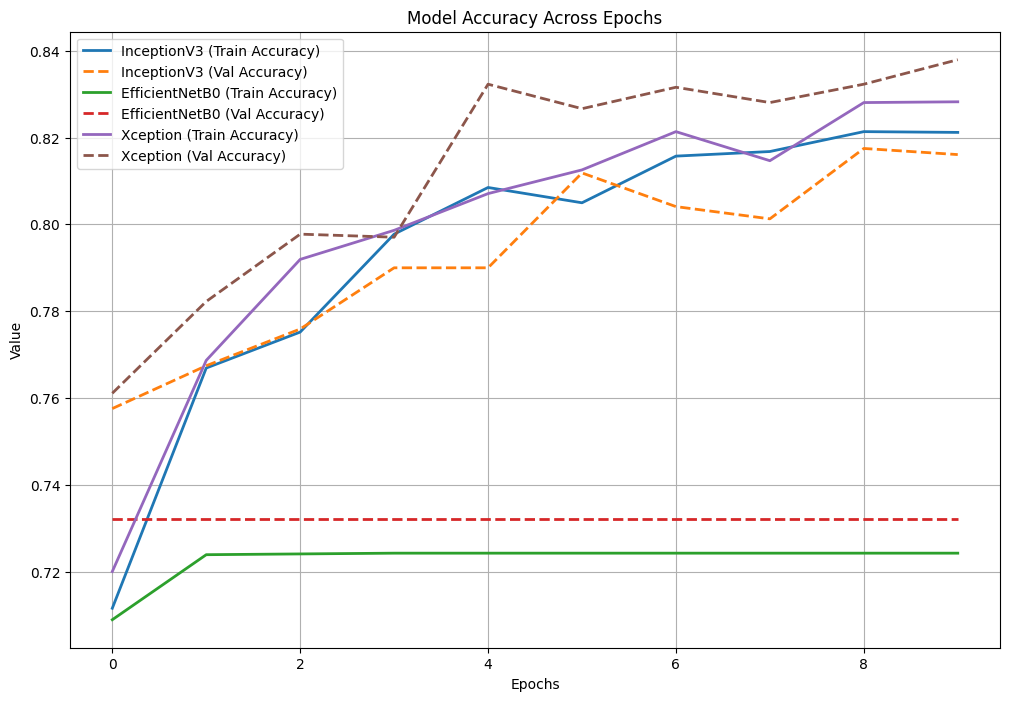

In [ ]:
# Plot the training model training and validation accuracy
plot_accuracy(model_results)

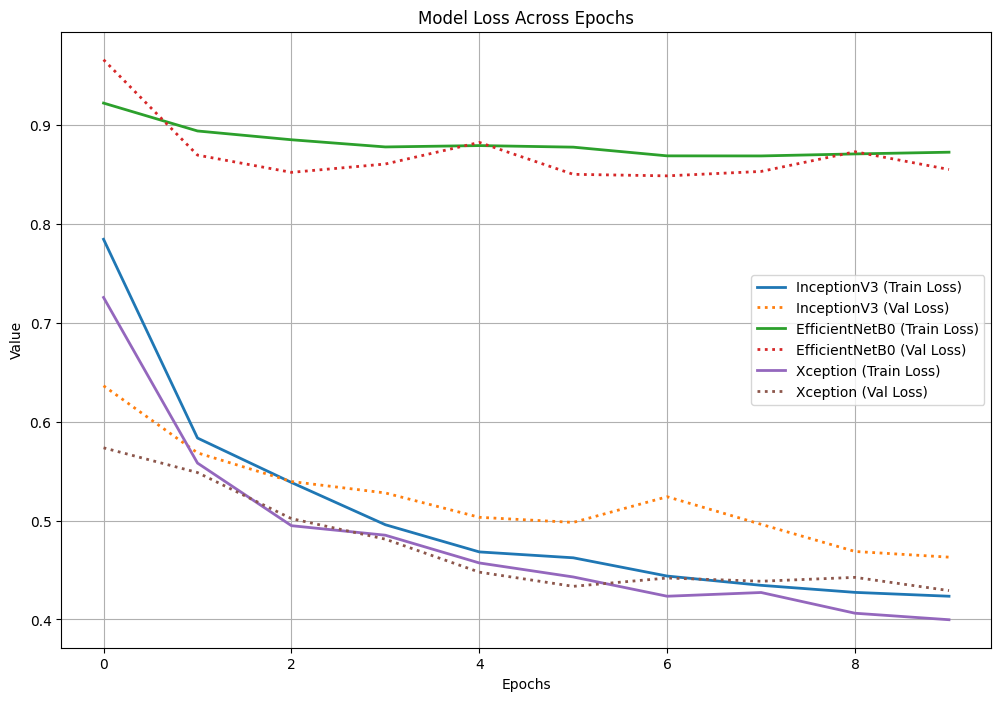

In [ ]:
# Plot the training model training and validation loss
plot_loss(model_results)

In [ ]:
def fine_tune_model(model, train_generator, val_generator, batch_size=32, epochs=10, fine_tune_at_layer=50, learning_rate=0.0001):

      #model.trainable = True
      fine_tune_at = fine_tune_at_layer  # Fine-tune from this layer onward (you can experiment with this value)

      # Freeze layers before the fine-tuning point
      for layer in model.layers[fine_tune_at:]:
          layer.trainable = True

      # Recompile the model (this is required after unfreezing layers)
      model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

      # Continue training with fine-tuning
      history_fine_tune = model.fit(
          train_generator,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=val_generator,
          callbacks=[early_stopping, model_checkpoint]
      )

      return history_fine_tune

In [ ]:
# Function to fine-tune all models in the provided dictionary
def fine_tune_models(models_dict, train_generator, val_generator, batch_size=32, epochs=10, unfreeze_from_layer=0, learning_rate=1e-5):
    fine_tuned_histories = {}

    for model_name, model_info in models_dict.items():
        print(f"Fine-tuning {model_name}...")

        # Get the model from the dictionary
        model = model_info['model']

        # Fine-tune the model
        history = fine_tune_model(model, train_generator, val_generator, batch_size, epochs, unfreeze_from_layer, learning_rate)

        # Store the fine-tuned model and history
        fine_tuned_histories[model_name] = {
            'model': model,
            'history': history,
            'batch_size': batch_size,
            'epochs': epochs
        }

    return fine_tuned_histories

In [ ]:
# Fine-tune the models starting from the 50th layer with a learning rate of 0.0001
fine_tuned_histories = fine_tune_models(model_results, train_generator, val_generator, batch_size=32, epochs=10, unfreeze_from_layer=50, learning_rate=0.0001)

Fine-tuning InceptionV3...
Epoch 1/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7449 - loss: 0.6921
Epoch 1: val_loss did not improve from 0.42924
178/178 ━━━━━━━━━━━━━━━━━━━━ 626s 3s/step - accuracy: 0.7450 - loss: 0.6916 - val_accuracy: 0.7597 - val_loss: 0.6415
Epoch 2/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8073 - loss: 0.4654
Epoch 2: val_loss did not improve from 0.42924
178/178 ━━━━━━━━━━━━━━━━━━━━ 618s 3s/step - accuracy: 0.8073 - loss: 0.4653 - val_accuracy: 0.8168 - val_loss: 0.4387
Epoch 3/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8405 - loss: 0.4020
Epoch 3: val_loss improved from 0.42924 to 0.39548, saving model to best_model.h5


178/178 ━━━━━━━━━━━━━━━━━━━━ 583s 3s/step - accuracy: 0.8405 - loss: 0.4020 - val_accuracy: 0.8351 - val_loss: 0.3955
Epoch 4/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8441 - loss: 0.3712
Epoch 4: val_loss improved from 0.39548 to 0.37716, saving model to best_model.h5


178/178 ━━━━━━━━━━━━━━━━━━━━ 577s 3s/step - accuracy: 0.8441 - loss: 0.3712 - val_accuracy: 0.8584 - val_loss: 0.3772
Epoch 5/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8571 - loss: 0.3334
Epoch 5: val_loss did not improve from 0.37716
178/178 ━━━━━━━━━━━━━━━━━━━━ 576s 3s/step - accuracy: 0.8571 - loss: 0.3334 - val_accuracy: 0.8400 - val_loss: 0.4110
Epoch 6/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8703 - loss: 0.3192
Epoch 6: val_loss did not improve from 0.37716
178/178 ━━━━━━━━━━━━━━━━━━━━ 586s 3s/step - accuracy: 0.8703 - loss: 0.3192 - val_accuracy: 0.8471 - val_loss: 0.4051
Epoch 7/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8787 - loss: 0.3025
Epoch 7: val_loss did not improve from 0.37716
178/178 ━━━━━━━━━━━━━━━━━━━━ 569s 3s/step - accuracy: 0.8787 - loss: 0.3025 - val_accuracy: 0.8548 - val_loss: 0.3927
Epoch 8/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8780 - loss: 0.2956
Epoch 8: val_loss did not improve from 0.37716


178/178 ━━━━━━━━━━━━━━━━━━━━ 1013s 6s/step - accuracy: 0.8656 - loss: 0.3299 - val_accuracy: 0.8703 - val_loss: 0.3719
Epoch 5/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.8739 - loss: 0.3070
Epoch 5: val_loss did not improve from 0.37191
178/178 ━━━━━━━━━━━━━━━━━━━━ 1013s 6s/step - accuracy: 0.8739 - loss: 0.3070 - val_accuracy: 0.8626 - val_loss: 0.3964
Epoch 6/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.8759 - loss: 0.2957
Epoch 6: val_loss did not improve from 0.37191
178/178 ━━━━━━━━━━━━━━━━━━━━ 1009s 6s/step - accuracy: 0.8759 - loss: 0.2957 - val_accuracy: 0.8541 - val_loss: 0.3979
Epoch 7/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.8851 - loss: 0.2821
Epoch 7: val_loss improved from 0.37191 to 0.35560, saving model to best_model.h5


178/178 ━━━━━━━━━━━━━━━━━━━━ 1004s 6s/step - accuracy: 0.8851 - loss: 0.2821 - val_accuracy: 0.8746 - val_loss: 0.3556
Epoch 8/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.8900 - loss: 0.2686
Epoch 8: val_loss did not improve from 0.35560
178/178 ━━━━━━━━━━━━━━━━━━━━ 1021s 6s/step - accuracy: 0.8900 - loss: 0.2687 - val_accuracy: 0.8732 - val_loss: 0.3612
Epoch 9/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.8842 - loss: 0.2723
Epoch 9: val_loss did not improve from 0.35560
178/178 ━━━━━━━━━━━━━━━━━━━━ 1037s 6s/step - accuracy: 0.8841 - loss: 0.2723 - val_accuracy: 0.8450 - val_loss: 0.4051
Epoch 10/10
101/178 ━━━━━━━━━━━━━━━━━━━━ 6:33 5s/step - accuracy: 0.9029 - loss: 0.2406

In [ ]:
# Accessing the fine tuned model results
for model_name, details in fine_tuned_histories.items():
    print(f"Results for {model_name}:")
    print(f" * Fine tuned Training Accuracy: {details['history'].history['accuracy'][-1]}")
    print(f" * Fine tuned Validation Accuracy: {details['history'].history['val_accuracy'][-1]}")
    print(f" * Fine tuned Training Loss: {details['history'].history['loss'][-1]}")
    print(f" * Fine tuned Validation Loss: {details['history'].history['val_loss'][-1]}")
    print("\n")

Results for InceptionV3:
 * Fine tuned Training Accuracy: 0.8801973462104797
 * Fine tuned Validation Accuracy: 0.858350932598114
 * Fine tuned Training Loss: 0.29150131344795227
 * Fine tuned Validation Loss: 0.3806813061237335


Results for EfficientNetB0:
 * Fine tuned Training Accuracy: 0.7943974733352661
 * Fine tuned Validation Accuracy: 0.7575757503509521
 * Fine tuned Training Loss: 0.48865455389022827
 * Fine tuned Validation Loss: 0.69825279712677


Results for Xception:
 * Fine tuned Training Accuracy: 0.8904157876968384
 * Fine tuned Validation Accuracy: 0.8618745803833008
 * Fine tuned Training Loss: 0.2580391466617584
 * Fine tuned Validation Loss: 0.3762108385562897




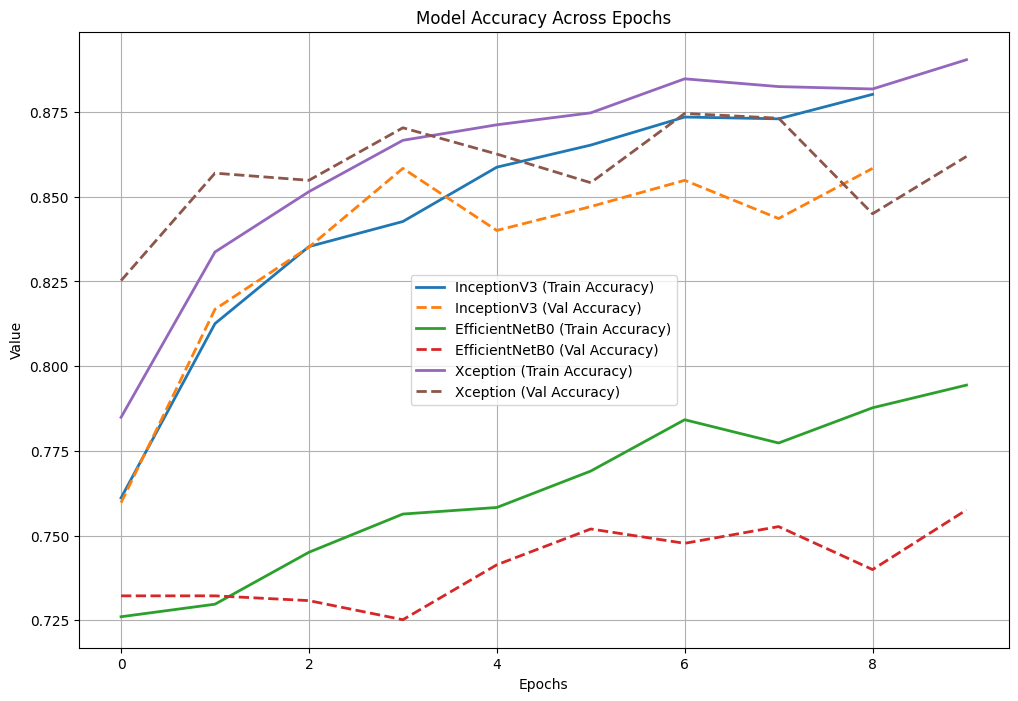

In [ ]:
# Plot the fine tuned model training and validation accuracy
plot_accuracy(fine_tuned_histories)

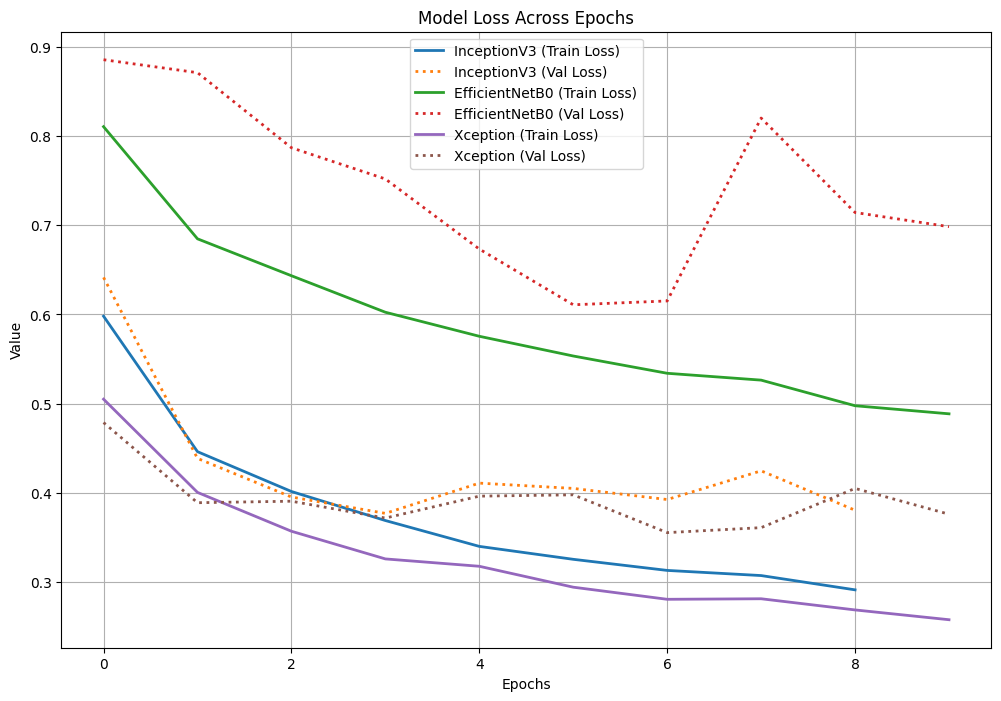

In [ ]:
# Plot the fine tuned model training and validation loss
plot_loss(fine_tuned_histories)